<a href="https://colab.research.google.com/github/kridtapon/GAPO-MACD-Surge/blob/main/GAPO_MACD_Surge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.2 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.52
    Uninstalling yfinance-0.2.52:
      Successfully uninstalled yfinance-0.2.52


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate Gopalakrishnan Range Index (GAPO)
def calculate_gapo(df, period=14):
    """
    Calculate Gopalakrishnan Range Index (GAPO).
    """
    high_low_range = df['High'].rolling(period).max() - df['Low'].rolling(period).min()
    log_n = np.log(period)
    log_range = np.log(high_low_range.replace(0, np.nan))  # Avoid log(0)

    gapo = log_range / log_n
    return gapo

# Function to calculate MACD and Signal Line
def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    """
    Calculate MACD and Signal Line.
    """
    short_ema = df['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = df['Close'].ewm(span=long_window, adjust=False).mean()

    macd = short_ema - long_ema
    macd_signal = macd.ewm(span=signal_window, adjust=False).mean()

    return macd, macd_signal

# Define the stock symbol and time period
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate GAPO
df['GAPO'] = calculate_gapo(df, period=14)

# Calculate MACD and Signal Line
df['MACD'], df['MACD_Signal'] = calculate_macd(df)

# Define Entry and Exit signals based on GAPO and MACD
df['Entry'] = (df['GAPO'] > 0.3) & (df['MACD'] > df['MACD_Signal'])
df['Exit'] = (df['GAPO'] > 0.7) & (df['MACD'] < df['MACD_Signal'])

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                            83739.278317
Total Return [%]                       -16.260722
Benchmark Return [%]                   180.172876
Max Gross Exposure [%]                      100.0
Total Fees Paid                       9338.419604
Max Drawdown [%]                        79.371889
Max Drawdown Duration                      1093.0
Total Trades                                   51
Total Closed Trades                            51
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            41.176471
Best Trade [%]                          47.066823
Worst Trade [%]                        -27.105326
Avg Winning Trade [%]                    9.367532
Avg Losing Trade [%]                    -5.988778


In [21]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools

# Function to calculate Gopalakrishnan Range Index (GAPO)
def calculate_gapo(df, period):
    high_low_range = df['High'].rolling(period).max() - df['Low'].rolling(period).min()
    log_n = np.log(period)
    log_range = np.log(high_low_range.replace(0, np.nan))  # Avoid log(0)
    return log_range / log_n

# Function to calculate MACD and Signal Line
def calculate_macd(df, short_window, long_window, signal_window):
    short_ema = df['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = df['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    macd_signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, macd_signal

# Define the stock symbol and time period
symbol = 'APO'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Define parameter ranges
gapo_periods = range(10, 31, 2)
macd_short_windows = range(5, 16, 2)
macd_long_windows = range(20, 35, 2)
macd_signal_windows = range(5, 16, 2)
entry_thresholds = [0.1, 0.2, 0.3, 0.4]
exit_thresholds = [0.6, 0.7, 0.8, 0.9]

# Generate all parameter combinations
param_combinations = list(itertools.product(
    gapo_periods, macd_short_windows, macd_long_windows, macd_signal_windows, entry_thresholds, exit_thresholds
))

# Initialize results list
results = []

# Iterate through each parameter combination
for gapo_period, short_window, long_window, signal_window, entry_threshold, exit_threshold in param_combinations:
    if entry_threshold >= exit_threshold:
        continue  # Skip invalid threshold combinations

    df['GAPO'] = calculate_gapo(df, gapo_period)
    df['MACD'], df['MACD_Signal'] = calculate_macd(df, short_window, long_window, signal_window)

    # Filter data for the test period (2020-2025)
    df_filtered = df[(df.index.year >= 2020) & (df.index.year <= 2025)].copy()

    # Define Entry and Exit signals AFTER filtering
    entries = (df_filtered['GAPO'] > entry_threshold) & (df_filtered['MACD'] > df_filtered['MACD_Signal'])
    exits = (df_filtered['GAPO'] > exit_threshold) & (df_filtered['MACD'] < df_filtered['MACD_Signal'])

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df_filtered['Close'],
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.001
    )

    # Store results
    total_return = portfolio.total_return()
    results.append((gapo_period, short_window, long_window, signal_window, entry_threshold, exit_threshold, total_return))

# Find the best parameter combination
best_params = max(results, key=lambda x: x[6])
print(f"Best Parameters: GAPO={best_params[0]}, MACD Short={best_params[1]}, MACD Long={best_params[2]}, MACD Signal={best_params[3]}, Entry Threshold={best_params[4]}, Exit Threshold={best_params[5]}")
print(f"Best Total Return: {best_params[6]:.2%}")

# Run backtest with best parameters
df['GAPO'] = calculate_gapo(df, best_params[0])
df['MACD'], df['MACD_Signal'] = calculate_macd(df, best_params[1], best_params[2], best_params[3])

# Filter data for the test period (2020-2025)
df_filtered = df[(df.index.year >= 2020) & (df.index.year <= 2025)].copy()

# Apply best thresholds AFTER filtering
entries = (df_filtered['GAPO'] > best_params[4]) & (df_filtered['MACD'] > df_filtered['MACD_Signal'])
exits = (df_filtered['GAPO'] > best_params[5]) & (df_filtered['MACD'] < df_filtered['MACD_Signal'])

# Ensure entries and exits have the same shape as df_filtered['Close']
entries, exits = entries.reindex(df_filtered.index, fill_value=False), exits.reindex(df_filtered.index, fill_value=False)

# Run final backtest
best_portfolio = vbt.Portfolio.from_signals(
    close=df_filtered['Close'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(best_portfolio.stats())

# Plot the best strategy
best_portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed


Best Parameters: GAPO=12, MACD Short=15, MACD Long=34, MACD Signal=15, Entry Threshold=0.1, Exit Threshold=0.7
Best Total Return: 316.12%
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           416118.359001
Total Return [%]                       316.118359
Benchmark Return [%]                   302.646996
Max Gross Exposure [%]                      100.0
Total Fees Paid                      12266.326781
Max Drawdown [%]                        36.051838
Max Drawdown Duration                       276.0
Total Trades                                   25
Total Closed Trades                            25
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 52.0
Best Trade [%]                           45.96306
Worst Trade 

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



In [23]:
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,402646.996309
Total Return [%],302.646996
Benchmark Return [%],302.646996
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],53.479443


[*********************100%***********************]  1 of 1 completed


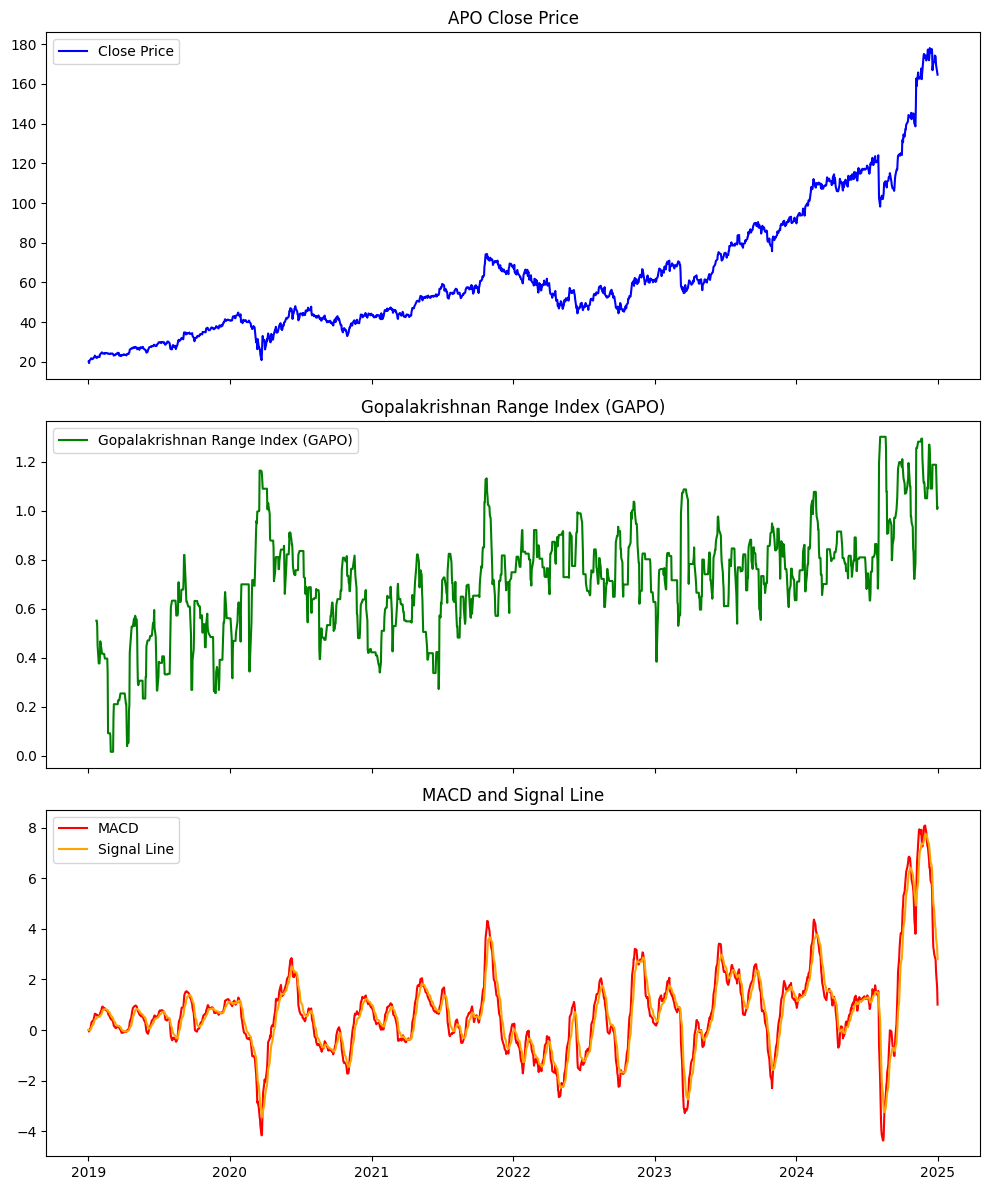

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Function to calculate Gopalakrishnan Range Index (GAPO)
def calculate_gapo(df, period):
    high_low_range = df['High'].rolling(period).max() - df['Low'].rolling(period).min()
    log_n = np.log(period)
    log_range = np.log(high_low_range.replace(0, np.nan))  # Avoid log(0)
    return log_range / log_n

# Function to calculate MACD and Signal Line
def calculate_macd(df, short_window, long_window, signal_window):
    short_ema = df['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = df['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    macd_signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, macd_signal

# Define the stock symbol and time period
symbol = 'APO'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate the Gopalakrishnan Range Index (GAPO) with a period of 14
gapo = calculate_gapo(df, 14)

# Calculate the MACD and Signal Line
macd, macd_signal = calculate_macd(df, short_window=12, long_window=26, signal_window=9)

# Plotting
fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot Close price
ax[0].plot(df['Close'], label='Close Price', color='blue')
ax[0].set_title(f'{symbol} Close Price')
ax[0].legend(loc='best')

# Plot GAPO
ax[1].plot(gapo, label='Gopalakrishnan Range Index (GAPO)', color='green')
ax[1].set_title('Gopalakrishnan Range Index (GAPO)')
ax[1].legend(loc='best')

# Plot MACD and Signal Line
ax[2].plot(macd, label='MACD', color='red')
ax[2].plot(macd_signal, label='Signal Line', color='orange')
ax[2].set_title('MACD and Signal Line')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()
